# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [74]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from math import *
def impurity(k1, k2):
    p1 = k1/(k1+k2)
    p2 = k2/(k1+k2)
    return round(-(p1*log(p1)+p2*log(p2)), 2)
print(f'Энтропия такого класса сотавляет: {impurity(8, 2)}')

Энтропия такого класса сотавляет: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [75]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
def Dzini(k1, k2):
    p1 = k1/(k1+k2)
    p2 = k2/(k1+k2)
    return round(p1*(1-p1)+p2*(1-p2), 2)

def Q(k1, k2, l1, l2, r1, r2):
    return Dzini(k1, k2) - (l1+l2)/(k1+k2)*Dzini(l1, l2) - (r1+r2)/(k1+k2)*Dzini(r1, r2)


print(f'Критерий информативности составляет: {Q(8,2,8,0,0,2)}')

Критерий информативности составляет: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [76]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
def lr_pred(value_list):
    return np.mean(value_list)
print(f'Предсказание модели для этих объектов будет равно: {lr_pred([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])}')

Предсказание модели для этих объектов будет равно: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [77]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [78]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо classification, либо regression
    :param feature_type: либо real, либо categorical
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ʖ╮•́)⊃¤=(————-
    # Создаем датафрейм значения признака -> метки класса (значения целевой переменной)
    thresholds_all = []
    thresholds = []
    ginis = []
    df = pd.DataFrame(np.vstack((feature_vector, target_vector)).T, columns=['X', 'y'])
    # Сортируем по возрастанию, чтобы потом перебирать пороги и смотреть те, при которых энтропия минимальна
    df.sort_values(by=["X"], inplace=True)
    df.reset_index(drop=True)
    # Создаем вектор со значениями порогов как среднее между соседними признаками
    for num_t in range(df.shape[0]-1):
        t = (df["X"].iloc[num_t] + df["X"].iloc[num_t+1])/2
        if t not in thresholds_all:
            thresholds_all.append(t)
    for t in range(len(thresholds_all)):
        left = target_vector[df["X"] < thresholds_all[t]]
        right = target_vector[df["X"] >= thresholds_all[t]]
        if (len(left) > 0) & (len(right) >0):
            if task == "regression":
                H_r = np.var(right)
                H_l = np.var(left)
            else:
                H_r = right[right==0].shape[0]/len(right)*(1-right[right==0].shape[0]/len(right)) + right[right==1].shape[0]/len(right)*(1-right[right==1].shape[0]/len(right))
                H_l = left[left==0].shape[0]/len(left)*(1-left[left==0].shape[0]/len(left)) + left[left==1].shape[0]/len(left)*(1-left[left==1].shape[0]/len(left))
            gini_on_first_level = len(left)/len(target_vector)*H_l + len(right)/len(target_vector)*H_r
            ginis.append(gini_on_first_level)
            thresholds.append(thresholds_all[t])
    gini_best = min(ginis)
    threshold_best = thresholds[ginis.index(gini_best)]
    return np.array(thresholds), np.array(ginis), float(threshold_best), float(gini_best)

Эту функцию можно протестировать на датасете `California`.

In [79]:
from sklearn.datasets import fetch_california_housing

In [80]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [81]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

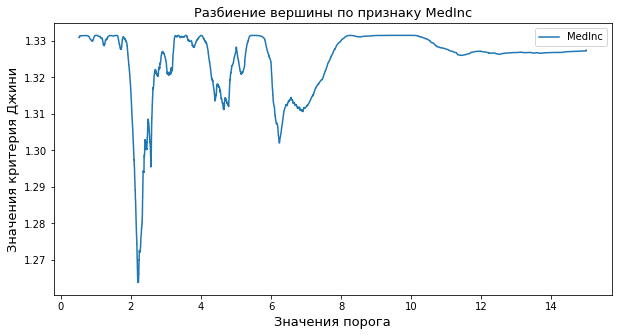

In [82]:
thresholds_MedInc, ginis_MedInc, threshold_best_Medinc, gini_best_MedInc = find_best_split(X["MedInc"], y, task="regression", feature_type="real")
plt.figure(figsize=(10, 5))
plt.plot(thresholds_MedInc, ginis_MedInc, label = "MedInc")
plt.xlabel("Значения порога", fontsize = 13)
plt.ylabel("Значения критерия Джини", fontsize = 13)
plt.title("Разбиение вершины по признаку MedInc", fontsize = 13)
plt.legend(loc = 1)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [83]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
threshold_best_Medinc

2.19745

Видим, что оптимальное значение ошибки соответствует значению порога **2.19745**. Там достигается минимальное значение критерия Джини, а значит при таком разбиении будет **наибольший информационный прирост**.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [84]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]): # Все объекты одного класса
            node["type"] = "terminal"
            node["class"] = sub_y[0] # У всех объектов в разбиении один и тот же класс, в разбиении создаем ключ со значением этого класса
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]): # Для каждого признака
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature] # Значения этого признака для всех объектов
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type) # Считается коэф Джини для каждого порога и выбирается наилучший порог и соответствующий ему критерий Джини
            
            # Ищем оптимальный признак и лучшее значение критерия Джини
            if gini_best is None or gini < gini_best: # Здесь знак меньше, потому что чем меньше неопределенность, тем лучше 
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = np.array(sub_X[:, feature] < threshold) # Добавил код
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = np.array(sub_X[:, feature] == threshold) # Добавил код
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"]) # Рекурсивно вызывается fit_node, разделяя левых детей до тех пор пока не выполнится критерий останова, после чего рекурсия разворачивается и идет вверх до места, где вызывается фит правой подвыборки, которая спустившись на один вправо снова идет рекурсивно влево, пока не выполнится критерий останова, так продолжается, пока дерево не отстроится
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        #
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [85]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv('students.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (258, 7)


,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [86]:
feature_names = ["STG", "SCG", "STR", "LPR", "PEG"]
X = pd.DataFrame(data=data, columns=feature_names)
y = data["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


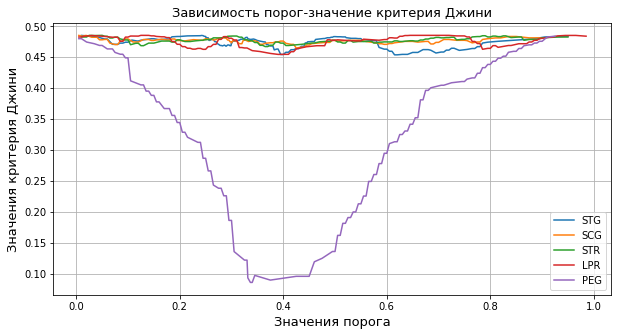

In [87]:
plt.figure(figsize=(10, 5))
plt.xlabel("Значения порога", fontsize = 13)
plt.ylabel("Значения критерия Джини", fontsize = 13)
plt.title("Зависимость порог-значение критерия Джини", fontsize = 13)
plt.grid()
for feature in feature_names:
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feature], y, task="classification")
    plt.plot(thresholds, ginis, label=feature)
plt.legend(loc=4)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

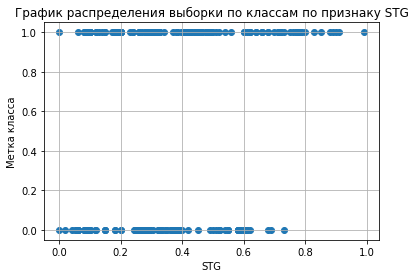

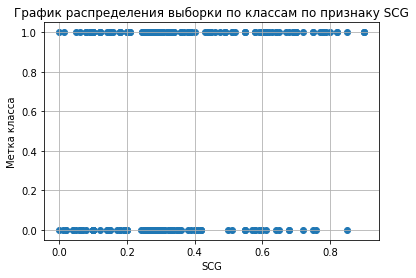

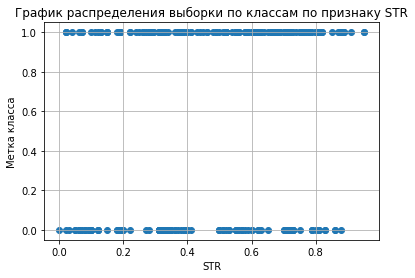

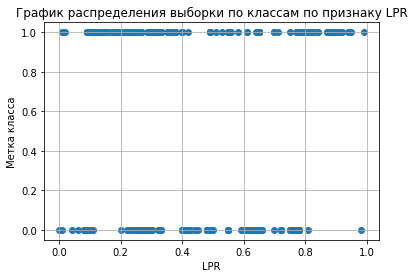

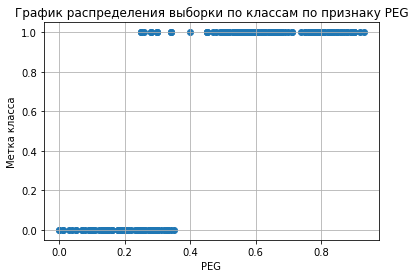

In [88]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
for feature in feature_names:
    plt.scatter(X[feature], y)
    plt.xlabel(feature)
    plt.ylabel('Метка класса')
    plt.title(f'График распределения выборки по классам по признаку {feature.strip()}')
    plt.grid()
    plt.show()

Судя по кривым деление выборки следует производить по признаку PEG (The exam performance of user for goal objects). Да, результат согласуется с визуальной оценкой диаграмм рассеяния, на графике распределения PEG и меток класса видно, что классы можно четко разделить по этому признаку. Чем более вогнутая кривая вниз, тем лучше выборка делится по этому признаку, потому что, чем меньше значение критерия Джини, тем больше информационный прирост и меньше неопределенность после разбиения. Выборку нельзя делить по кривым, значение которых почти константно находится вблизи 0.5, потому что для критерия Джини 0.5 плохой информационный прирост и больше неопределенность после разбиения.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [89]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data = pd.read_fwf("agaricus-lepiota.data")
data.head()

,"p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u"
0,"e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g"
1,"e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m"
2,"p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u"
3,"e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g"
4,"e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g"


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [90]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [91]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

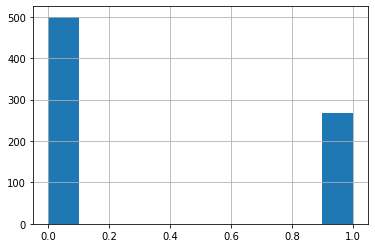

In [92]:
data['Outcome'].hist()
plt.show()

Нулевого класса заметно больше, чем первого.

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [93]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
feature_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
X = pd.DataFrame(data=data, columns=feature_names)
y = data["Outcome"]
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [94]:
y

0 1
1 0
2 1
3 0
4 1
 ..
763 0
764 0
765 0
766 1
767 0
Name: Outcome, Length: 768, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=123)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [96]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.metrics import f1_score
max_depth_list = [i for i in range(1,30)]
min_samples_leaf_list = [k for k in range(1,20)]
f1_best_value = 0
for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        DTC = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=123)
        DTC.fit(X_train1, y_train1)
        y_pred = DTC.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        if f1 > f1_best_value:
            f1_best_value = f1
            max_depth_best = max_depth
            min_samples_leaf_best = min_samples_leaf

print(f'Наилучшее качество дает пара значений max_depth: {max_depth_best} и min_samples_leaf: {min_samples_leaf_best}')
print(f'При таких значениях гиперпараметров метрика качества f1 составит: {round(f1_best_value, 4)}')

Наилучшее качество дает пара значений max_depth: 3 и min_samples_leaf: 1
При таких значениях гиперпараметров метрика качества f1 составит: 0.6168


In [97]:
DTC = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=123)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: {round(f1, 4)}')
print('Другие метрики качества равны')
print(f'accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'auc-roc: {round(roc_auc_score(y_test, DTC.predict_proba(X_test)[:, 1]), 4)}')

f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: 0.4878
Другие метрики качества равны
accuracy: 0.7273
precision: 0.8571
recall: 0.3409
auc-roc: 0.7448


Почти все метрики качества принимают хорошее значение, за исключением recall и f1 меры, что говорит о том, что построенная модель **плохо обнаруживает положительный класс** (плохой recall), когда предсказывает положительный класс в большинстве случаев оказывается права (хороший precision). Хорошая площадь под ROC кривой, достаточно близка к единице

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [98]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
base_tree = DecisionTreeClassifier()
BC = BaggingClassifier(base_tree, n_estimators=50, random_state=123)
BC.fit(X_train, y_train)
y_pred = BC.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: {round(f1, 4)}')
print('Другие метрики качества равны')
print(f'accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'auc-roc: {round(roc_auc_score(y_test, BC.predict_proba(X_test)[:, 1]), 4)}')

f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: 0.7126
Другие метрики качества равны
accuracy: 0.7835
precision: 0.7209
recall: 0.7045
auc-roc: 0.8572


Видим значительное улучшение метрик качества. Независимое обучение деревьев улучшило результат, значения метрик качества увеличились. Значение precision чуть-чуть упало, что говорит о том, что модель чаще ошибается, когда предсказывает положительный класс, чем обученное решающее дерево. Но в целом качество на тестовых данных увеличилось, модель стала более устойчивой к изменениям в выборке (разброс уменьшился).

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [99]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import cross_val_score
max_depth_list = [i for i in range(1,10)]
min_samples_split_list = [2**k for k in range(1,6)]
results = {}
for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        RF = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=123)
        scores = cross_val_score(RF, X_train, y_train, cv=5, scoring = "f1_macro")
        results[(max_depth, min_samples_split)] = np.mean(scores)
best_params = max(results, key=results.get)
print(f"Best parameters: {best_params}, mean f1-macro: {results[best_params]}")

Best parameters: (7, 16), mean f1-macro: 0.7317303507315271


In [100]:
RF = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_split=16, random_state=123)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print(f'f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: {round(f1_score(y_test, y_pred), 4)}')
print('Другие метрики качества равны')
print(f'accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'precision: {round(precision_score(y_test, y_pred), 4)}')
print(f'recall: {round(recall_score(y_test, y_pred), 4)}')
print(f'auc-roc: {round(roc_auc_score(y_test, RF.predict_proba(X_test)[:, 1]), 4)}')

f1 метрика качества решающего дерева с подобранными на валиде гиперпараметрами составляет: 0.6667
Другие метрики качества равны
accuracy: 0.7662
precision: 0.7297
recall: 0.6136
auc-roc: 0.8651


Каждая модель имеет свои особенности, однако лучшей в целом в нашем случае оказалась модель с бэггиингом деревьев. Это может быть связано с тем, что в случайном лесу часть важных признаков отсеивалась, что влияло на метрики качества, а решающее дерево по сравнению со своими более сложными аналогами имеет больший разброс и показывает плохое качество на тестовых данных.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

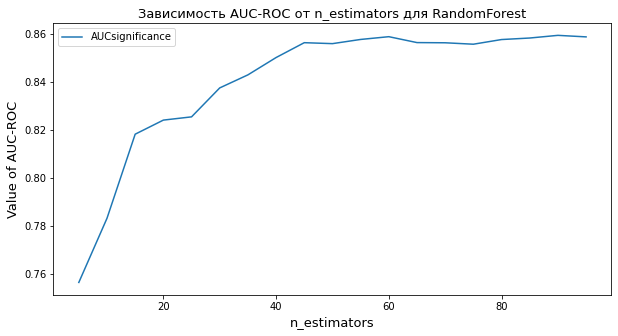

In [101]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n_estimators = [i*5 for i in range(1, 20)]
auc_roc_values = []
for n in n_estimators:
    RF = RandomForestClassifier(n_estimators=n, random_state=123)
    RF.fit(X_train, y_train)
    auc_roc = roc_auc_score(y_test, RF.predict_proba(X_test)[:, 1])
    auc_roc_values.append(auc_roc)
plt.figure(figsize=(10, 5))
plt.title("Зависимость AUC-ROC от n_estimators для RandomForest", fontsize=13)
plt.xlabel("n_estimators", fontsize=13)
plt.ylabel("Value of AUC-ROC", fontsize=13)
plt.plot(n_estimators, auc_roc_values, label="AUCsignificance")
plt.legend(loc=2)
plt.show()

По графику можно сделать вывод, что c ростом числа деревьев в случайном лесу площадь под ROC кривой становится все ближе к единице, то есть при большем числе деревьев качество случайного леса лучше. Однако есть "предел насыщения", после которого с ростом числа деревьев AUC-ROC необязательно растет, а может и падать.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [102]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————